In [23]:
my_data=[['slashdot','USA','no',18,'None'],
        ['google','France','yes',23,'Premium'],
        ['digg','USA','yes',24,'Basic'],
        ['kiwitobes','France','yes',23,'Basic'],
        ['google','UK','no',21,'Premium'],
        ['(direct)','New Zealand','no',12,'None'],
        ['(direct)','UK','no',21,'Basic'],
        ['google','USA','no',24,'Premium'],
        ['slashdot','France','yes',19,'None'],
        ['digg','USA','no',18,'None'],
        ['google','UK','no',18,'None'],
        ['kiwitobes','UK','no',19,'None'],
        ['digg','New Zealand','yes',12,'Basic'],
        ['slashdot','UK','no',21,'None'],
        ['google','UK','yes',18,'Basic'],
        ['kiwitobes','France','yes',19,'Basic']]

In [24]:
class decisionnode:
  def __init__(self,col=-1,value=None,results=None,tb=None,fb=None):
    self.col=col
    print(col)
    self.value=value
    print(value)
    self.results=results
    print(results)
    self.tb=tb
    print(tb)
    self.fb=fb
    print(fb)

# Divides a set on a specific column. Can handle numeric
# or nominal values
def divideset(rows,column,value):
   # Make a function that tells us if a row is in 
   # the first group (true) or the second group (false)
   split_function=None
   if isinstance(value,int) or isinstance(value,float):
      split_function=lambda row:row[column]>=value
   else:
      split_function=lambda row:row[column]==value
   
   # Divide the rows into two sets and return them
   set1=[row for row in rows if split_function(row)]
   set2=[row for row in rows if not split_function(row)]
   return (set1,set2)

In [25]:
divideset(my_data,4,'Basic')

([['digg', 'USA', 'yes', 24, 'Basic'],
  ['kiwitobes', 'France', 'yes', 23, 'Basic'],
  ['(direct)', 'UK', 'no', 21, 'Basic'],
  ['digg', 'New Zealand', 'yes', 12, 'Basic'],
  ['google', 'UK', 'yes', 18, 'Basic'],
  ['kiwitobes', 'France', 'yes', 19, 'Basic']],
 [['slashdot', 'USA', 'no', 18, 'None'],
  ['google', 'France', 'yes', 23, 'Premium'],
  ['google', 'UK', 'no', 21, 'Premium'],
  ['(direct)', 'New Zealand', 'no', 12, 'None'],
  ['google', 'USA', 'no', 24, 'Premium'],
  ['slashdot', 'France', 'yes', 19, 'None'],
  ['digg', 'USA', 'no', 18, 'None'],
  ['google', 'UK', 'no', 18, 'None'],
  ['kiwitobes', 'UK', 'no', 19, 'None'],
  ['slashdot', 'UK', 'no', 21, 'None']])

In [26]:
# Create counts of possible results (the last column of 
# each row is the result)
def uniquecounts(rows):
   results={}
   for row in rows:
      # The result is the last column
      r=row[len(row)-1]
      if r not in results: results[r]=0
      results[r]+=1
   return results

In [27]:
# Probability that a randomly placed item will
# be in the wrong category
def giniimpurity(rows):
  total=len(rows)
  counts=uniquecounts(rows)
  imp=0
  for k1 in counts:
    p1=float(counts[k1])/total
    for k2 in counts:
      if k1==k2: continue
      p2=float(counts[k2])/total
      imp+=p1*p2
  return imp

In [28]:
# Entropy is the sum of p(x)log(p(x)) across all 
# the different possible results
def entropy(rows):
   from math import log
   log2=lambda x:log(x)/log(2)  
   results=uniquecounts(rows)
   # Now calculate the entropy
   ent=0.0
   for r in results.keys():
      p=float(results[r])/len(rows)
      ent=ent-p*log2(p)
   return ent

In [29]:
def variance(rows):
  if len(rows)==0: return 0
  data=[float(row[len(row)-1]) for row in rows]
  mean=sum(data)/len(data)
  variance=sum([(d-mean)**2 for d in data])/len(data)
  return variance

In [30]:
giniimpurity(my_data)

0.6328125

In [31]:
entropy(my_data)

1.5052408149441479

In [32]:
uniquecounts(my_data)

{'Basic': 6, 'None': 7, 'Premium': 3}

In [33]:
set1,set2=divideset(my_data,2,'yes')

In [34]:
entropy(set1)

1.1488348542809168

In [35]:
entropy(set2)

1.224394445405986

In [36]:
def buildtree(rows,scoref=entropy):
  if len(rows)==0: return decisionnode()
  current_score=scoref(rows)

  # Set up some variables to track the best criteria
  best_gain=0.0
  best_criteria=None
  best_sets=None
  
  column_count=len(rows[0])-1
  for col in range(0,column_count):
    # Generate the list of different values in
    # this column
    column_values={}
    for row in rows:
       column_values[row[col]]=1
    # Now try dividing the rows up for each value
    # in this column
    for value in column_values.keys():
      (set1,set2)=divideset(rows,col,value)
      
      # Information gain
      p=float(len(set1))/len(rows)
      gain=current_score-p*scoref(set1)-(1-p)*scoref(set2)
      if gain>best_gain and len(set1)>0 and len(set2)>0:
        best_gain=gain
        best_criteria=(col,value)
        best_sets=(set1,set2)
  # Create the sub branches   
  if best_gain>0:
    trueBranch=buildtree(best_sets[0])
    falseBranch=buildtree(best_sets[1])
    return decisionnode(col=best_criteria[0],value=best_criteria[1],
                        tb=trueBranch,fb=falseBranch)
  else:
    return decisionnode(results=uniquecounts(rows))

In [37]:
dtree = buildtree(my_data)

-1
None
{'Premium': 3}
None
None
-1
None
{'None': 1}
None
None
-1
None
{'Basic': 1}
None
None
2
no
None
3
21
None
-1
None
{'None': 1}
None
None
-1
None
{'Basic': 4}
None
None
0
slashdot
None
-1
None
{'None': 1}
None
None
-1
None
{'Basic': 1}
None
None
1
New Zealand
None
-1
None
{'None': 4}
None
None
0
(direct)
None
2
yes
None
0
google
None


In [38]:
def printtree(tree,indent=''):
   # Is this a leaf node?
   if tree.results!=None:
      print (str(tree.results))
   else:
      # Print the criteria
      print (str(tree.col)+':'+str(tree.value)+'? ')

      # Print the branches
      print (indent+'T->'),
      printtree(tree.tb,indent+'  ')
      print (indent+'F->'),
      printtree(tree.fb,indent+'  ')


def getwidth(tree):
  if tree.tb==None and tree.fb==None: return 1
  return getwidth(tree.tb)+getwidth(tree.fb)

def getdepth(tree):
  if tree.tb==None and tree.fb==None: return 0
  return max(getdepth(tree.tb),getdepth(tree.fb))+1

In [39]:
printtree(dtree)

0:google? 
T->
3:21? 
  T->
{'Premium': 3}
  F->
2:no? 
    T->
{'None': 1}
    F->
{'Basic': 1}
F->
2:yes? 
  T->
0:slashdot? 
    T->
{'None': 1}
    F->
{'Basic': 4}
  F->
0:(direct)? 
    T->
1:New Zealand? 
      T->
{'None': 1}
      F->
{'Basic': 1}
    F->
{'None': 4}


In [40]:
from PIL import Image,ImageDraw

def drawtree(tree,jpeg='tree.jpg'):
  w=getwidth(tree)*100
  h=getdepth(tree)*100+120

  img=Image.new('RGB',(w,h),(255,255,255))
  draw=ImageDraw.Draw(img)

  drawnode(draw,tree,w/2,20)
  img.save(jpeg,'JPEG')
  
def drawnode(draw,tree,x,y):
  if tree.results==None:
    # Get the width of each branch
    w1=getwidth(tree.fb)*100
    w2=getwidth(tree.tb)*100

    # Determine the total space required by this node
    left=x-(w1+w2)/2
    right=x+(w1+w2)/2

    # Draw the condition string
    draw.text((x-20,y-10),str(tree.col)+':'+str(tree.value),(0,0,0))

    # Draw links to the branches
    draw.line((x,y,left+w1/2,y+100),fill=(255,0,0))
    draw.line((x,y,right-w2/2,y+100),fill=(255,0,0))
    
    # Draw the branch nodes
    drawnode(draw,tree.fb,left+w1/2,y+100)
    drawnode(draw,tree.tb,right-w2/2,y+100)
  else:
    txt=' \n'.join(['%s:%d'%v for v in tree.results.items()])
    draw.text((x-20,y),txt,(0,0,0))

In [41]:
drawtree(dtree,jpeg='treeview.jpg')

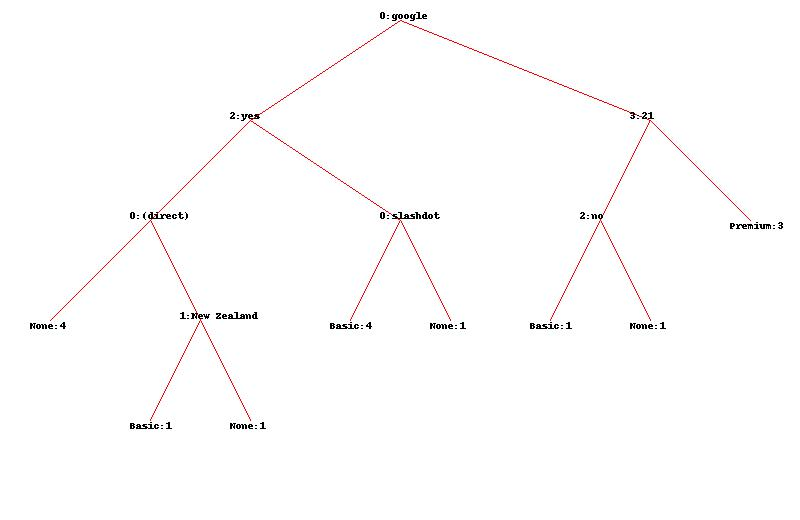

In [42]:
from IPython.display import Image
Image(filename='treeview.jpg')

In [43]:
def classify(observation,tree):
  if tree.results!=None:
    return tree.results
  else:
    v=observation[tree.col]
    branch=None
    if isinstance(v,int) or isinstance(v,float):
      if v>=tree.value: branch=tree.tb
      else: branch=tree.fb
    else:
      if v==tree.value: branch=tree.tb
      else: branch=tree.fb
    return classify(observation,branch)

In [44]:
classify(['(direct)','USA','yes',5],dtree)

{'Basic': 4}